# SNR value range
This notebook aims to understand what values of SNR are acceptable to be used. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, fftfreq, fftshift
import pyMRI.pymri as pymri
from pyMRI.utils import RMSE

In [2]:
metabolites = pymri.METABOLITES

In [3]:
sampling_f = 100000 # cycles/s -> 2000 cycles/s -> 2048 points
t0 = 0.0
tn = 1.0
Dt = tn - t0
dt = 1.0/(sampling_f)
B0 = 3.0

In [4]:
deltas = np.array(list(metabolites.values()))[:, 0]
t2s = np.array(list(metabolites.values()))[:, 1]
M_0s = np.array(list(metabolites.values()))[:, 2]
spins_phi = np.zeros_like(deltas)
ws = pymri.hz_to_rad(pymri.f_from_chem_shift(deltas, B0) )

print( pymri.rad_to_hz(ws) )
print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

[374.84360487 383.83596833 397.33728675 397.97594892 418.92406833
 428.50400098 515.52810921 539.03087732 543.75697743 584.00546781
 593.45766803 611.35298223 632.42883407 654.4115862 ]
All frequencies are captured by the sampling rate.


In [5]:
sig, t = pymri.population_transverse_decay(0.0, 1.0, 1.0, (ws, t2s, M_0s, spins_phi), np.array([]))

P = np.abs(sig)[0]
print(P)

2.4412


Now, the sigma will have values that range from a low value up to a realtive high value:

In [38]:
sigmas = np.array([0.05, 0.15, 0.3, 0.5, 0.75, 1.0, 3.0, 5.0, 7.0])

pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay(t0, tn, dt, pop, np.array([]))
sig_fft = fftshift(fft(sig, sig.size))
P_fft = np.nanmax(sig_fft)

sigma = 1.0
center = 0.0
a = 1.0


corrup_signals = np.zeros((sigmas.size, sig.size), dtype = np.complex128)
corrup_signals_fft = np.zeros((sigmas.size, sig.size), dtype = np.complex128)
snr = np.zeros_like(sigmas)
snr_fft = np.zeros_like(sigmas)
print

for i in range(sigmas.size):
    corrup_signals[i, :] = pymri.corrupted_snr(sig, center, sigmas[i])
    snr[i] = pymri.snr(np.abs(corrup_signals[i, :]))

    corrup_signals_fft[i, :] = fftshift(fft(corrup_signals[i, :], corrup_signals[i, :].size))
    snr_fft[i] = pymri.snr(corrup_signals_fft[i, :]) 
    
freqs = pymri.chem_shift_from_f(fftshift(fftfreq(corrup_signals[0, :].size, d = dt)), B0)

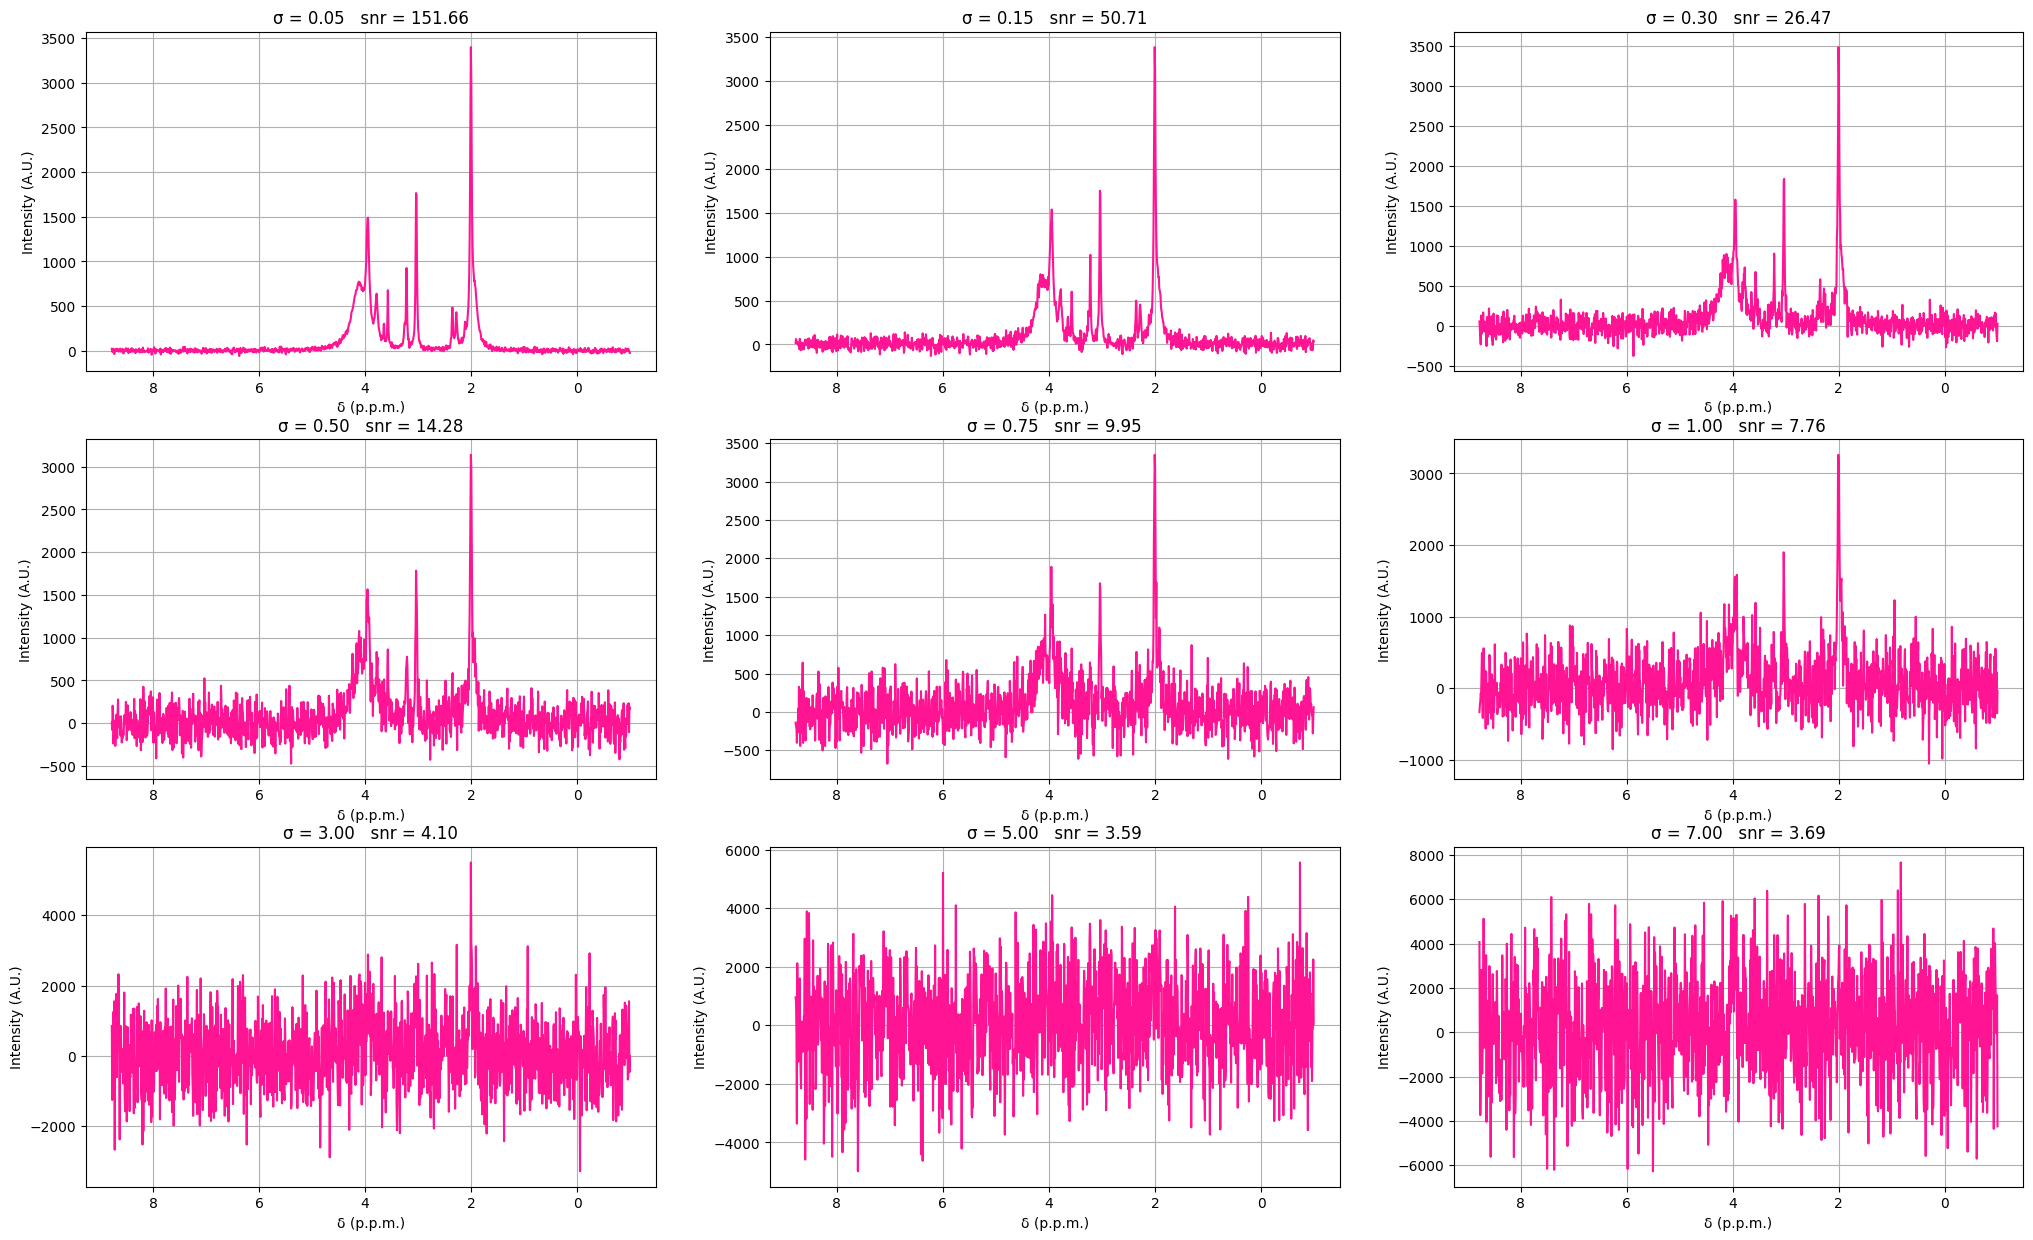

In [39]:
n_sigma = sigmas.shape[0]

l1 = np.floor(np.sqrt(n_sigma))
l2 = np.ceil(n_sigma / l1)
img_size = 3.0

sub = l1*100 + l2*10 + 1

plt.figure(figsize = (25, 15))
for i in range(n_sigma):
    plt.subplot(int(sub + i))
    pymri.plot_chem_shifts(freqs, corrup_signals_fft[i, :], 0.05,  ("σ = {:.2f}").format(sigmas[i]) + ("   snr = {:.2f}").format(snr_fft[i]))

plt.show()

From above, it seems like a $\sigma$ of value up to $3$, that corresponds to a $SNR = 4.10$ approximately is close to the boundary of $\sigma$ where the peak of the signal is confused with the random noise-generated signal. Hence, it seems unecessary to study $\sigma$ values above the one mentioned.